In [2]:
# Install required packages for Python 3.7 compatibility
# !pip install dowhy
# !pip install causalnex
# !pip install shap

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Causal inference
import dowhy
from dowhy import CausalModel

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Statistical analysis
from scipy import stats
import networkx as nx

print("All libraries imported successfully!")


All libraries imported successfully!


# 1.Load and preprocess contribution data

In [3]:
# Load the datasets
contribution_data = pd.read_excel('/content/Additional Contribution Rate per Year and Quarter.xlsx')
morbidity_data = pd.read_excel('/content/Morbidity_Region.xlsx', sheet_name='data')

print("Contribution Data Shape:", contribution_data.shape)
print("Morbidity Data Shape:", morbidity_data.shape)
print("\nContribution Data Columns:", list(contribution_data.columns))
print("\nMorbidity Data Columns:", list(morbidity_data.columns))


Contribution Data Shape: (5415, 6)
Morbidity Data Shape: (1073, 6)

Contribution Data Columns: ['Year', 'Insurance Provider', 'Quarter', 'Members', 'Insured people', 'Additional contribution rate in %']

Morbidity Data Columns: ['Krankenkasse ( statutory insurance provider)', 'Risikofaktor (risk factor)', 'RF-Entwicklung im Vgl zum Vorjahr (risk factor development in comparision to the previous year)', 'Regionalität (regionality)', 'Regionale Verteilung (regionality distribution) ', 'Jahr (year)']


In [4]:
contribution_data.head()

,Year,Insurance Provider,Quarter,Members,Insured people,Additional contribution rate in %
0,2025,AOK Baden-Württemberg,1,3539685,4615478,2.60
1,2025,AOK Bayern,1,3627408,4603276,2.69
2,2025,AOK Bremen/Bremerhaven,1,207431,284469,2.49
3,2025,AOK Hessen,1,1281555,1730176,2.49
4,2025,AOK Niedersachsen,1,2324317,3058918,2.70


In [5]:
# Clean column names
contribution_data.columns = ['Year', 'Insurance_Provider', 'Quarter', 'Members',
                           'Insured_People', 'Additional_Contribution_Rate']

# Convert to numeric
numeric_cols = ['Members', 'Insured_People', 'Additional_Contribution_Rate']
for col in numeric_cols:
    contribution_data[col] = pd.to_numeric(contribution_data[col], errors='coerce')

# Remove rows with missing critical data
contribution_data = contribution_data.dropna(subset=['Members', 'Additional_Contribution_Rate'])

print(f"Data after cleaning: {contribution_data.shape[0]} rows")
print(f"Date range: {contribution_data['Year'].min()} - {contribution_data['Year'].max()}")
print(f"Unique providers: {contribution_data['Insurance_Provider'].nunique()}")


Data after cleaning: 5415 rows
Date range: 2013 - 2025
Unique providers: 131


In [13]:
morbidity_df = pd.read_excel('Morbidity_Region.xlsx').rename(
columns={'Jahr (year)': 'Year', 'Krankenkasse ( statutory insurance provider)': 'Insurance Provider'}
).dropna().drop_duplicates()

In [6]:
# Aggregate quarterly data to yearly
yearly_contribution = contribution_data.groupby(['Year', 'Insurance_Provider']).agg({
    'Members': 'mean',  # Average members across quarters
    'Insured_People': 'mean',  # Average insured people across quarters
    'Additional_Contribution_Rate': 'mean'  # Average contribution rate across quarters
}).reset_index()

print(f"Yearly aggregated data shape: {yearly_contribution.shape}")
print(f"Years available: {sorted(yearly_contribution['Year'].unique())}")


Yearly aggregated data shape: (1426, 5)
Years available: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [7]:
def calculate_churn_rate(df):
    """Calculate yearly churn rate based on membership changes"""
    df = df.sort_values(['Insurance_Provider', 'Year'])
    df['Previous_Members'] = df.groupby('Insurance_Provider')['Members'].shift(1)

    # Calculate churn rate as percentage decrease in membership
    df['Members_Change'] = df['Members'] - df['Previous_Members']
    df['Churn_Rate'] = np.where(
        df['Previous_Members'] > 0,
        -df['Members_Change'] / df['Previous_Members'],  # Negative change = churn
        0
    )

    # Cap churn rate between 0 and 1 for realistic values
    df['Churn_Rate'] = np.clip(df['Churn_Rate'], 0, 1)

    return df

# Calculate churn rates
yearly_contribution = calculate_churn_rate(yearly_contribution)

# Remove first year data (no previous year for comparison)
yearly_contribution = yearly_contribution.dropna(subset=['Previous_Members'])

print(f"Data with churn rates: {yearly_contribution.shape}")
print(f"\nChurn rate statistics:")
print(yearly_contribution['Churn_Rate'].describe())


Data with churn rates: (1295, 8)

Churn rate statistics:
count    1295.000000
mean        0.003831
std         0.011027
min         0.000000
25%         0.000000
50%         0.000000
75%         0.002240
max         0.210392
Name: Churn_Rate, dtype: float64


In [9]:
# Clean morbidity data column names
morbidity_data.columns = ['Insurance_Provider', 'Risk_Factor', 'Risk_Factor_Change',
                         'Regionality', 'Regional_Distribution', 'Year']

# Convert numeric columns
morbidity_data['Risk_Factor'] = pd.to_numeric(morbidity_data['Risk_Factor'], errors='coerce')
morbidity_data['Risk_Factor_Change'] = pd.to_numeric(morbidity_data['Risk_Factor_Change'], errors='coerce')

# Merge datasets
merged_data = pd.merge(
    yearly_contribution,
    morbidity_data[['Insurance_Provider', 'Year', 'Risk_Factor', 'Risk_Factor_Change', 'Regionality']],
    on=['Insurance_Provider', 'Year'],
    how='inner'
)

print(f"Merged data shape: {merged_data.shape}")
print(f"Missing values per column:")
print(merged_data.isnull().sum())


Merged data shape: (928, 11)
Missing values per column:
Year                            0
Insurance_Provider              0
Members                         0
Insured_People                  0
Additional_Contribution_Rate    0
Previous_Members                0
Members_Change                  0
Churn_Rate                      0
Risk_Factor                     1
Risk_Factor_Change              4
Regionality                     0
dtype: int64


# 2.Feature Engineering

In [10]:
def calculate_contribution_rate_change(df):
    """Calculate year-over-year change in contribution rates"""
    df = df.sort_values(['Insurance_Provider', 'Year'])
    df['Previous_Contribution_Rate'] = df.groupby('Insurance_Provider')['Additional_Contribution_Rate'].shift(1)
    df['Contribution_Rate_Change'] = df['Additional_Contribution_Rate'] - df['Previous_Contribution_Rate']
    return df

# Calculate treatment variable
merged_data = calculate_contribution_rate_change(merged_data)

# Remove rows without previous year data
merged_data = merged_data.dropna(subset=['Previous_Contribution_Rate'])

print(f"Final dataset shape: {merged_data.shape}")


Final dataset shape: (824, 13)


In [11]:
# Create fund size categories based on membership
merged_data['Fund_Size'] = pd.cut(
    merged_data['Members'],
    bins=[0, 100000, 1000000, 5000000, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Very_Large']
)

# Encode categorical variables
label_encoder = LabelEncoder()
merged_data['Regionality_Encoded'] = label_encoder.fit_transform(merged_data['Regionality'].fillna('Unknown'))
merged_data['Fund_Size_Encoded'] = label_encoder.fit_transform(merged_data['Fund_Size'].astype(str))

# Create binary treatment variable (above median increase)
contribution_median = merged_data['Contribution_Rate_Change'].median()
merged_data['Treatment'] = (merged_data['Contribution_Rate_Change'] > contribution_median).astype(int)

# Normalize continuous variables
scaler = StandardScaler()
continuous_vars = ['Risk_Factor', 'Members', 'Insured_People']
for var in continuous_vars:
    merged_data[f'{var}_Normalized'] = scaler.fit_transform(merged_data[[var]])

print(f"Treatment distribution:")
print(merged_data['Treatment'].value_counts())
print(f"\nContribution rate change statistics:")
print(merged_data['Contribution_Rate_Change'].describe())


Treatment distribution:
Treatment
0    483
1    341
Name: count, dtype: int64

Contribution rate change statistics:
count    824.000000
mean       0.213750
std        0.434223
min       -0.800000
25%        0.000000
50%        0.000000
75%        0.300000
max        2.400000
Name: Contribution_Rate_Change, dtype: float64


In [12]:
# Fill missing values with median for numeric variables
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].median())

# Final dataset preparation
final_data = merged_data.dropna(subset=['Churn_Rate', 'Treatment'])

print(f"Final clean dataset shape: {final_data.shape}")
print(f"Missing values: {final_data.isnull().sum().sum()}")


Final clean dataset shape: (824, 20)
Missing values: 0


# 3.Causal Model and Causal Graph


In [13]:
# Define the causal graph structure
causal_graph = """
digraph {
    Treatment -> Churn_Rate;
    Risk_Factor_Normalized -> Churn_Rate;
    Risk_Factor_Normalized -> Treatment;
    Fund_Size_Encoded -> Churn_Rate;
    Fund_Size_Encoded -> Treatment;
    Regionality_Encoded -> Churn_Rate;
    Regionality_Encoded -> Treatment;
    Year -> Churn_Rate;
    Year -> Treatment;
}
"""

print("Causal Graph Defined:")
print(causal_graph)


Causal Graph Defined:

digraph {
    Treatment -> Churn_Rate;
    Risk_Factor_Normalized -> Churn_Rate;
    Risk_Factor_Normalized -> Treatment;
    Fund_Size_Encoded -> Churn_Rate;
    Fund_Size_Encoded -> Treatment;
    Regionality_Encoded -> Churn_Rate;
    Regionality_Encoded -> Treatment;
    Year -> Churn_Rate;
    Year -> Treatment;
}



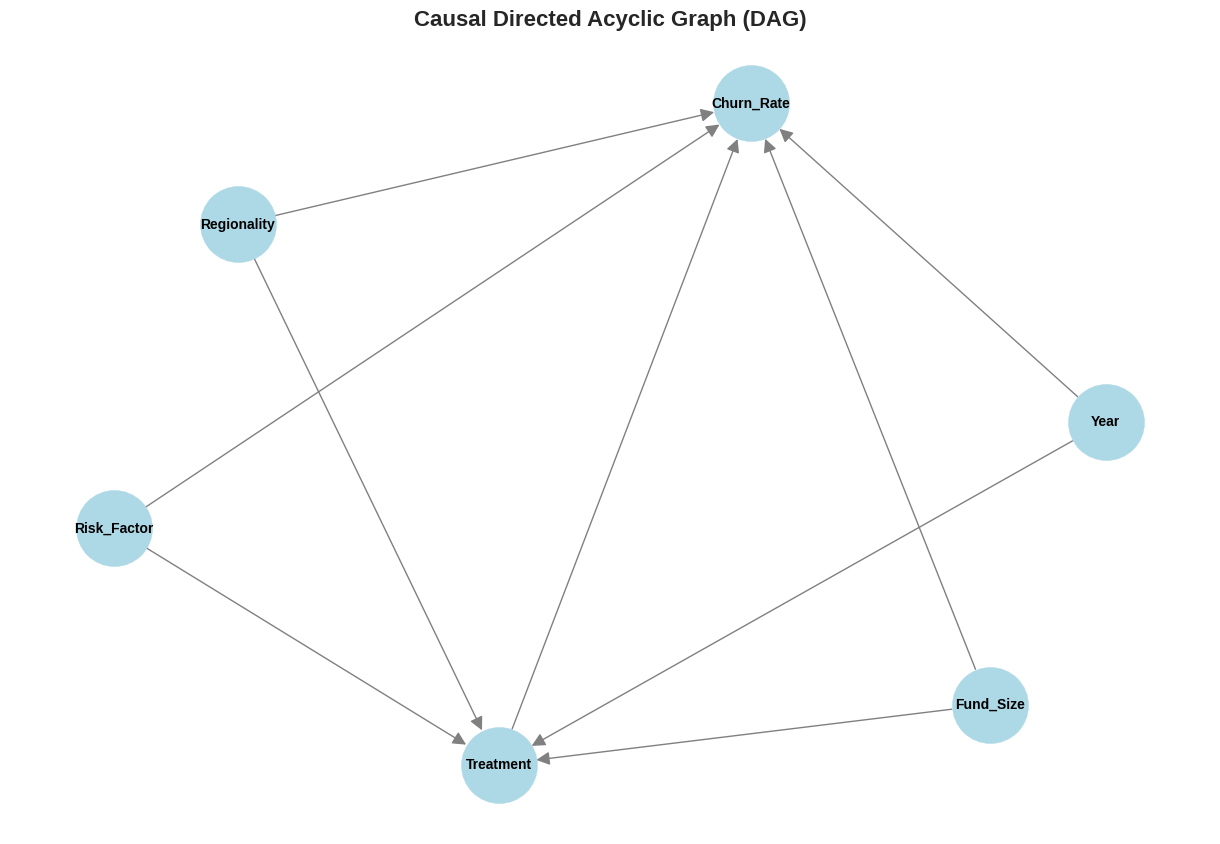

In [14]:
# Create networkx graph for visualization
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
edges = [
    ('Treatment', 'Churn_Rate'),
    ('Risk_Factor', 'Churn_Rate'),
    ('Risk_Factor', 'Treatment'),
    ('Fund_Size', 'Churn_Rate'),
    ('Fund_Size', 'Treatment'),
    ('Regionality', 'Churn_Rate'),
    ('Regionality', 'Treatment'),
    ('Year', 'Churn_Rate'),
    ('Year', 'Treatment')
]

G.add_edges_from(edges)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray')
plt.title("Causal Directed Acyclic Graph (DAG)", fontsize=16, fontweight='bold')
plt.show()


# 4.Causal Effect estimation

In [19]:
# Prepare data for DoWhy
causal_data = final_data[[
    'Treatment', 'Churn_Rate', 'Risk_Factor_Normalized',
    'Fund_Size_Encoded', 'Regionality_Encoded', 'Year'
]].copy()

# Create DoWhy causal model
model = CausalModel(
    data=causal_data,
    treatment='Treatment',
    outcome='Churn_Rate',
    graph=causal_graph,
    common_causes=['Risk_Factor_Normalized', 'Fund_Size_Encoded', 'Regionality_Encoded', 'Year']
)

print("Causal Model Created Successfully!")
print(f"Treatment: {model._treatment}")
print(f"Outcome: {model._outcome}")
print(f"Common causes: {model.get_common_causes()}")


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Causal Model Created Successfully!
Treatment: ['Treatment']
Outcome: ['Churn_Rate']
Common causes: ['Fund_Size_Encoded', 'Regionality_Encoded', 'Year', 'Risk_Factor_Normalized']


In [20]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identification Complete!")
print(identified_estimand)


Identification Complete!
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[Churn_Rate|Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Fact ↪
d[Treatment]                                                                   ↪

↪                
↪ or_Normalized])
↪                
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Churn_Rate then P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized,U) = P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
# Estimate causal effect using backdoor criterion
estimate_backdoor = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
)

print("Backdoor Estimation Results:")
print(estimate_backdoor)
print(f"\nAverage Treatment Effect (ATE): {estimate_backdoor.value:.6f}")


Backdoor Estimation Results:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[Churn_Rate|Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Fact ↪
d[Treatment]                                                                   ↪

↪                
↪ or_Normalized])
↪                
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Churn_Rate then P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized,U) = P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized)

## Realized estimand
b: Churn_Rate~Treatment+Fund_Size_Encoded+Regionality_Encoded+Year+Risk_Factor_Normalized
Target units: ate

## Estimate
Mean value: 0.0025767813317613695


Average Treatment Effect (ATE): 0.002577


In [22]:
#  propensity score matching
try:
    estimate_psm = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching"
    )
    print("Propensity Score Matching Results:")
    print(estimate_psm)
    print(f"ATE (PSM): {estimate_psm.value:.6f}")
except Exception as e:
    print(f"PSM estimation failed: {e}")

# Try inverse propensity weighting
try:
    estimate_ipw = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_weighting"
    )
    print("\nInverse Propensity Weighting Results:")
    print(estimate_ipw)
    print(f"ATE (IPW): {estimate_ipw.value:.6f}")
except Exception as e:
    print(f"IPW estimation failed: {e}")


Propensity Score Matching Results:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[Churn_Rate|Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Fact ↪
d[Treatment]                                                                   ↪

↪                
↪ or_Normalized])
↪                
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Churn_Rate then P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized,U) = P(Churn_Rate|Treatment,Fund_Size_Encoded,Regionality_Encoded,Year,Risk_Factor_Normalized)

## Realized estimand
b: Churn_Rate~Treatment+Fund_Size_Encoded+Regionality_Encoded+Year+Risk_Factor_Normalized
Target units: ate

## Estimate
Mean value: 0.003897829312637074

ATE (PSM): 0.003898

Inverse Propensity Weighting Results:
*** Causal

## Refutation test

In [23]:
# Refute using random common cause
refute_random = model.refute_estimate(
    identified_estimand,
    estimate_backdoor,
    method_name="random_common_cause"
)
print("Refutation - Random Common Cause:")
print(refute_random)


Refutation - Random Common Cause:
Refute: Add a random common cause
Estimated effect:0.0025767813317613695
New effect:0.002581348200178562
p value:0.94



In [24]:
# Refute using placebo treatment
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate_backdoor,
    method_name="placebo_treatment_refuter"
)
print("Refutation - Placebo Treatment:")
print(refute_placebo)


Refutation - Placebo Treatment:
Refute: Use a Placebo Treatment
Estimated effect:0.0025767813317613695
New effect:0.00022512794061182426
p value:0.76



In [25]:
# Refute using data subset
refute_subset = model.refute_estimate(
    identified_estimand,
    estimate_backdoor,
    method_name="data_subset_refuter",
    subset_fraction=0.8
)
print("Refutation - Data Subset:")
print(refute_subset)


Refutation - Data Subset:
Refute: Use a subset of data
Estimated effect:0.0025767813317613695
New effect:0.002569354540851635
p value:0.98



# 5. Causal-Informed Predictive Modeling

## 5.1 Preparation of data for predictive modelling

In [26]:
# Create features including causal estimates
prediction_features = final_data[[
    'Risk_Factor_Normalized', 'Fund_Size_Encoded', 'Regionality_Encoded',
    'Year', 'Additional_Contribution_Rate', 'Members_Normalized',
    'Insured_People_Normalized', 'Contribution_Rate_Change'
]].copy()

# Add causal effect as feature
prediction_features['Causal_ATE'] = estimate_backdoor.value

# Add individual treatment effects (approximate)
prediction_features['Individual_Treatment_Effect'] = (
    prediction_features['Additional_Contribution_Rate'] * estimate_backdoor.value
)

# Add propensity scores if available
try:
    # Calculate propensity scores
    from sklearn.linear_model import LogisticRegression

    ps_model = LogisticRegression(random_state=42)
    ps_features = prediction_features[['Risk_Factor_Normalized', 'Fund_Size_Encoded',
                                     'Regionality_Encoded', 'Year']]
    ps_model.fit(ps_features, final_data['Treatment'])
    prediction_features['Propensity_Score'] = ps_model.predict_proba(ps_features)[:, 1]

    print("Propensity scores calculated and added as features")
except Exception as e:
    print(f"Could not calculate propensity scores: {e}")

print(f"Prediction features shape: {prediction_features.shape}")
print(f"Feature columns: {list(prediction_features.columns)}")


Propensity scores calculated and added as features
Prediction features shape: (824, 11)
Feature columns: ['Risk_Factor_Normalized', 'Fund_Size_Encoded', 'Regionality_Encoded', 'Year', 'Additional_Contribution_Rate', 'Members_Normalized', 'Insured_People_Normalized', 'Contribution_Rate_Change', 'Causal_ATE', 'Individual_Treatment_Effect', 'Propensity_Score']


## 5.2 Split the data

In [27]:
# Prepare target variable
y = final_data['Churn_Rate']
X = prediction_features

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=final_data['Treatment']
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (659, 11)
Test set size: (165, 11)


## 5.3 Train predictive model


In [28]:
# Train Gradient Boosting Model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Train Ridge Regression Model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

print("Models trained successfully!")


Models trained successfully!


## 5.4 Evaluate predictive model

In [29]:
# Calculate metrics for both models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

gb_metrics = evaluate_model(y_test, gb_pred, "Gradient Boosting")
ridge_metrics = evaluate_model(y_test, ridge_pred, "Ridge Regression")



Gradient Boosting Performance:
RMSE: 0.007926
MAE: 0.003992
R²: -0.684331

Ridge Regression Performance:
RMSE: 0.006203
MAE: 0.004482
R²: -0.031777


## 5.5 Model Interpretation

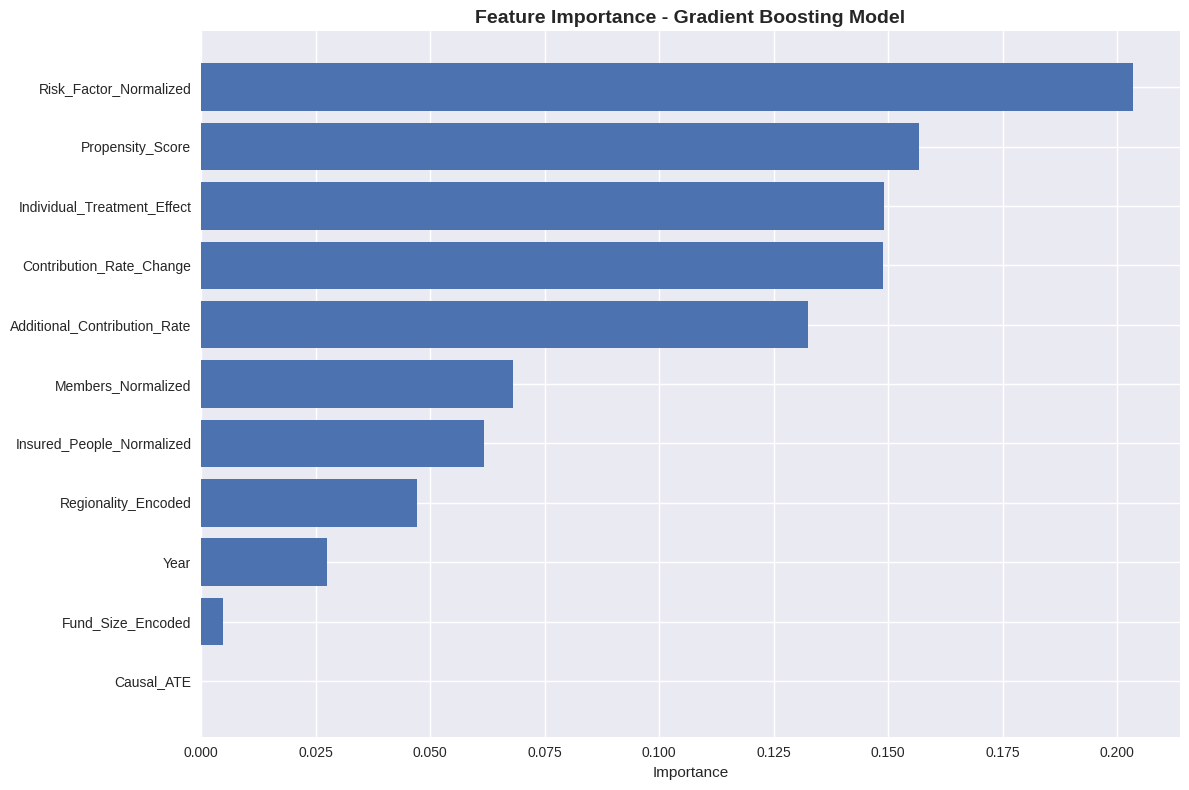


Top 5 Most Important Features:
                         Feature  Importance
4   Additional_Contribution_Rate    0.132431
7       Contribution_Rate_Change    0.148796
9    Individual_Treatment_Effect    0.149049
10              Propensity_Score    0.156828
0         Risk_Factor_Normalized    0.203533


In [30]:
# Plot feature importance for Gradient Boosting
feature_names = X.columns
gb_importance = gb_model.feature_importances_

plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importance
}).sort_values('Importance', ascending=True)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance - Gradient Boosting Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance_df.tail())


In [31]:
# Train baseline model without causal features
baseline_features = X.drop(columns=['Causal_ATE', 'Individual_Treatment_Effect'], errors='ignore')
if 'Propensity_Score' in baseline_features.columns:
    baseline_features = baseline_features.drop(columns=['Propensity_Score'])

X_train_baseline = baseline_features.loc[X_train.index]
X_test_baseline = baseline_features.loc[X_test.index]

# Train baseline model
baseline_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

baseline_model.fit(X_train_baseline, y_train)
baseline_pred = baseline_model.predict(X_test_baseline)

baseline_metrics = evaluate_model(y_test, baseline_pred, "Baseline (No Causal Features)")

# Compare models
print(f"\n{'='*50}")
print("MODEL COMPARISON")
print(f"{'='*50}")
print(f"{'Model':<30} {'RMSE':<12} {'MAE':<12} {'R²':<12}")
print(f"{'-'*66}")
print(f"{'Baseline':<30} {baseline_metrics['RMSE']:<12.6f} {baseline_metrics['MAE']:<12.6f} {baseline_metrics['R2']:<12.6f}")
print(f"{'Ridge (Causal)':<30} {ridge_metrics['RMSE']:<12.6f} {ridge_metrics['MAE']:<12.6f} {ridge_metrics['R2']:<12.6f}")
print(f"{'Gradient Boosting (Causal)':<30} {gb_metrics['RMSE']:<12.6f} {gb_metrics['MAE']:<12.6f} {gb_metrics['R2']:<12.6f}")



Baseline (No Causal Features) Performance:
RMSE: 0.007728
MAE: 0.003752
R²: -0.601202

MODEL COMPARISON
Model                          RMSE         MAE          R²          
------------------------------------------------------------------
Baseline                       0.007728     0.003752     -0.601202   
Ridge (Causal)                 0.006203     0.004482     -0.031777   
Gradient Boosting (Causal)     0.007926     0.003992     -0.684331   


# 6. Results Visualization and Interpretation

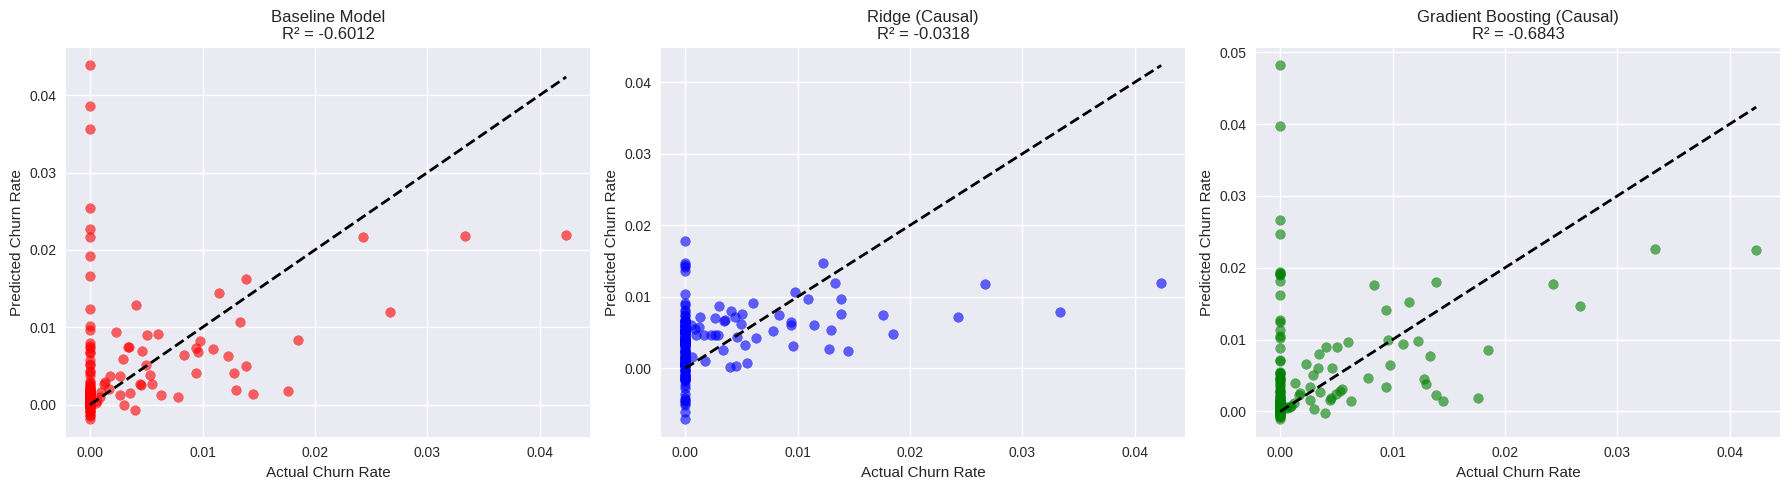

In [32]:
# Create prediction plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline model
axes[0].scatter(y_test, baseline_pred, alpha=0.6, color='red')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[0].set_xlabel('Actual Churn Rate')
axes[0].set_ylabel('Predicted Churn Rate')
axes[0].set_title(f'Baseline Model\nR² = {baseline_metrics["R2"]:.4f}')

# Ridge model
axes[1].scatter(y_test, ridge_pred, alpha=0.6, color='blue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[1].set_xlabel('Actual Churn Rate')
axes[1].set_ylabel('Predicted Churn Rate')
axes[1].set_title(f'Ridge (Causal)\nR² = {ridge_metrics["R2"]:.4f}')

# Gradient Boosting model
axes[2].scatter(y_test, gb_pred, alpha=0.6, color='green')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[2].set_xlabel('Actual Churn Rate')
axes[2].set_ylabel('Predicted Churn Rate')
axes[2].set_title(f'Gradient Boosting (Causal)\nR² = {gb_metrics["R2"]:.4f}')

plt.tight_layout()
plt.show()


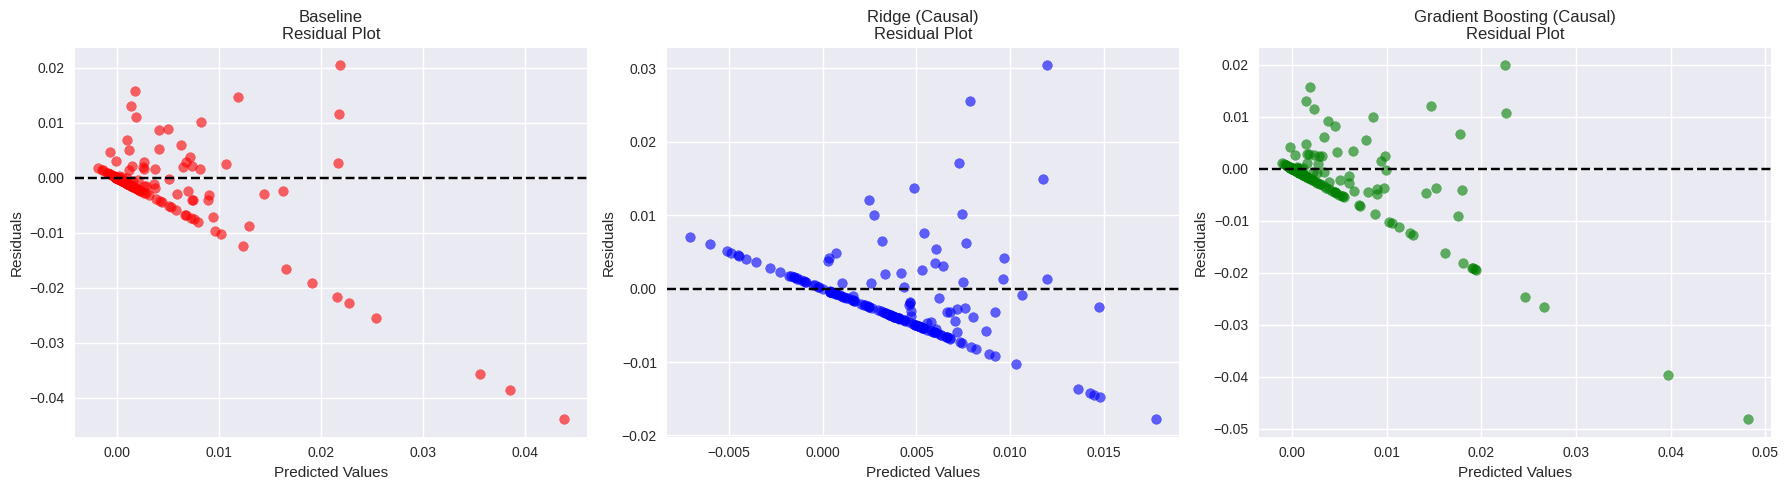

In [33]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Baseline', baseline_pred, 'red'),
    ('Ridge (Causal)', ridge_pred, 'blue'),
    ('Gradient Boosting (Causal)', gb_pred, 'green')
]

for i, (name, pred, color) in enumerate(models):
    residuals = y_test - pred
    axes[i].scatter(pred, residuals, alpha=0.6, color=color)
    axes[i].axhline(y=0, color='black', linestyle='--')
    axes[i].set_xlabel('Predicted Values')
    axes[i].set_ylabel('Residuals')
    axes[i].set_title(f'{name}\nResidual Plot')

plt.tight_layout()
plt.show()
